In [1]:
import sys
sys.path.append(r"D:\AI - ML - DL\Pytorch - Deep Learning\deep_learning_trainning\Segmentation Problems\UNET Architecture\Unet on TGS Salt Segmentation Dataset")


In [2]:
# USAGE
# python train.py
# import the necessary packages
from pyimagesearch.dataset import SegmentationDataset
from pyimagesearch.model import UNet
from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

Absolute path: D:\AI - ML - DL\Pytorch - Deep Learning\deep_learning_trainning\Segmentation Problems\UNET Architecture\Unet on TGS Salt Segmentation Dataset\dataset\train


In [4]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
						 test_size=config.TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()


[INFO] saving testing image paths...


In [5]:

# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
					   config.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
						 batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
						 num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
						batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
						num_workers=os.cpu_count())


[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [6]:

# initialize our UNet model
unet = UNet().to(config.DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))



[INFO] training the network...


  2%|▎         | 1/40 [01:05<42:23, 65.22s/it]

[INFO] EPOCH: 1/40
Train loss: 0.584432, Test loss: 0.6067


  5%|▌         | 2/40 [02:07<40:12, 63.49s/it]

[INFO] EPOCH: 2/40
Train loss: 0.569765, Test loss: 0.5893


  8%|▊         | 3/40 [03:10<39:01, 63.27s/it]

[INFO] EPOCH: 3/40
Train loss: 0.510383, Test loss: 0.5270


 10%|█         | 4/40 [04:11<37:21, 62.28s/it]

[INFO] EPOCH: 4/40
Train loss: 0.448149, Test loss: 0.4746


 12%|█▎        | 5/40 [05:11<35:58, 61.66s/it]

[INFO] EPOCH: 5/40
Train loss: 0.423738, Test loss: 0.4221


 15%|█▌        | 6/40 [06:17<35:37, 62.86s/it]

[INFO] EPOCH: 6/40
Train loss: 0.412713, Test loss: 0.5647


 18%|█▊        | 7/40 [07:19<34:30, 62.75s/it]

[INFO] EPOCH: 7/40
Train loss: 0.465325, Test loss: 0.4544


 20%|██        | 8/40 [08:23<33:37, 63.04s/it]

[INFO] EPOCH: 8/40
Train loss: 0.427544, Test loss: 0.4225


 22%|██▎       | 9/40 [09:26<32:40, 63.23s/it]

[INFO] EPOCH: 9/40
Train loss: 0.408380, Test loss: 0.4571


 25%|██▌       | 10/40 [10:30<31:42, 63.42s/it]

[INFO] EPOCH: 10/40
Train loss: 0.408949, Test loss: 0.4225


 28%|██▊       | 11/40 [11:29<29:56, 61.94s/it]

[INFO] EPOCH: 11/40
Train loss: 0.396052, Test loss: 0.3997


 30%|███       | 12/40 [12:27<28:23, 60.85s/it]

[INFO] EPOCH: 12/40
Train loss: 0.390137, Test loss: 0.4223


 32%|███▎      | 13/40 [13:26<27:07, 60.27s/it]

[INFO] EPOCH: 13/40
Train loss: 0.379361, Test loss: 0.4010


 35%|███▌      | 14/40 [14:25<25:54, 59.79s/it]

[INFO] EPOCH: 14/40
Train loss: 0.376880, Test loss: 0.3874


 38%|███▊      | 15/40 [15:24<24:48, 59.52s/it]

[INFO] EPOCH: 15/40
Train loss: 0.373354, Test loss: 0.4511


 40%|████      | 16/40 [16:22<23:39, 59.15s/it]

[INFO] EPOCH: 16/40
Train loss: 0.373403, Test loss: 0.3669


 42%|████▎     | 17/40 [17:24<22:59, 59.99s/it]

[INFO] EPOCH: 17/40
Train loss: 0.362509, Test loss: 0.3778


 45%|████▌     | 18/40 [18:24<22:00, 60.02s/it]

[INFO] EPOCH: 18/40
Train loss: 0.353277, Test loss: 0.3742


 48%|████▊     | 19/40 [19:25<21:08, 60.41s/it]

[INFO] EPOCH: 19/40
Train loss: 0.358699, Test loss: 0.4054


 50%|█████     | 20/40 [20:29<20:27, 61.37s/it]

[INFO] EPOCH: 20/40
Train loss: 0.397983, Test loss: 0.3928


 50%|█████     | 20/40 [21:27<21:27, 64.39s/it]


KeyboardInterrupt: 

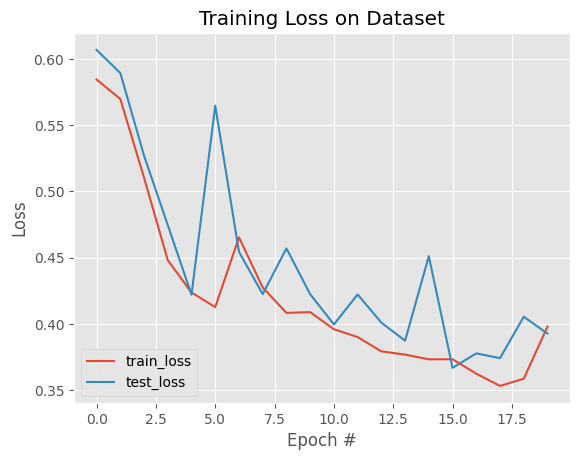

In [7]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)